# MOSAIKS Hands-on Session: Modeling LSMS Outcomes

This notebook demonstrates the application of Multi-task Observation using Satellite Imagery & Kitchen Sinks (MOSAIKS), a machine learning approach utilizing satellite imagery, to model LSMS survey data in Togo from 2018.


## Methodology

[Data license](https://datacatalog.worldbank.org/public-licenses#cc-by)


[Data description](https://microdata.worldbank.org/index.php/catalog/4298/study-description)

Results from simple models.

| variable | description | score |
|---|---|---|
| elec_ac | Acces reseau electrique | 0.6713 |
| telpor | Individu a telephone portable | 0.6338 |
| altitude | COORDONNEES GPS DU VILLAGE OU DU QUARTIER: Longitude | 0.5880 |
| agemar | Age premier marriage | 0.5500 |
| hh_size | Taille menage | 0.4288 |
| annual_hh_consumption | Conso annuelle totale menage | 0.4210 |
| n_adults | Nbr adultes-equiv. FAO | 0.3872 |
| wellbeing | Indicateur de bien-être | 0.2678 |


## Setup

This notebook utilizes several key Python libraries:

* **Data Handling and Analysis:**  `pandas` and `numpy` provide fundamental data structures and functions for manipulating and analyzing data. `geopandas` extends these capabilities to work with geospatial data.
* **Visualization:** `matplotlib.pyplot` and `seaborn` enable the creation of static and interactive visualizations, aiding in data exploration and result presentation.
* **Machine Learning:** `sklearn` offers a comprehensive suite of tools for building and evaluating machine learning models, including algorithms like Ridge Regression and methods for data preprocessing.

In [2]:
# !pip install mapclassify

In [3]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from google.colab import drive
from sklearn.linear_model import RidgeClassifier, RidgeCV
from sklearn.calibration import IsotonicRegression
from sklearn.metrics import roc_auc_score, roc_curve, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

## Mounting Google Drive

Mounting Google Drive in Colab essentially connects your Google Drive storage to the Colab environment. This allows you to access files and folders stored in your Drive directly within your Colab notebook. Think of it as creating a shortcut to your Drive within Colab.

**Why is this necessary?**

Colab notebooks run on temporary virtual machines. Mounting your Drive ensures that you can load and save data to your personal storage, persisting even after the Colab session ends. It also enables seamless access to larger datasets stored in your Drive, which would be impractical to upload directly to Colab.

After mounting Google Drive, we then define the path to the project folder on Google Drive. This directory contains the data files needed for the analysis.

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
drive_directory = os.path.join(
    "/",
    "content",
    "drive",
    "Shareddrives",
    "MOSAIKS Workshop",
    "Data",
)

## Create a local directory

This section creates a local directory within the Colab environment to store the project data. Data files are copied from the Google Drive directory to this local folder.

**Why use a local directory?**  

Accessing data locally on the Colab virtual machine (VM) significantly improves processing speed compared to reading directly from Google Drive. While copying the data initially takes a bit of time, this is outweighed by the performance gains during analysis.

In [6]:
local_dir = "/content/data/"

os.makedirs(local_dir, exist_ok=True)

files_to_copy = os.path.join(drive_directory, "lsms_data")

shutil.copytree(files_to_copy, local_dir, dirs_exist_ok=True)

'/content/data/'

Here we take a look at the contents of the local drive to ensure we have the necessary files copied.

In [7]:
!ls -lh /content/data

total 1.1G
-r-------- 1 root root 1.1G Nov 11 07:09 global_quarterly_2018q4_features.feather
-r-------- 1 root root  39M Nov 12 19:37 lsms_clean.csv


In [8]:
lsms = pd.read_csv(os.path.join(local_dir, "lsms_clean.csv") )
lsms.head()

,elec_ac,telpor,agemar,n_adults,wellbeing,annual_hh_consumption,hh_size,altitude,planet_0,planet_1,...,planet_3990,planet_3991,planet_3992,planet_3993,planet_3994,planet_3995,planet_3996,planet_3997,planet_3998,planet_3999
0,0.888889,0.714286,28.000000,1.886667,1.511325e+06,3.425003e+06,2.333333,35.900002,0.598209,0.311995,...,1.634288,3.556764,1.678105,0.656086,1.914035,1.086555,1.735920,0.176737,1.372976,3.784427
1,0.875000,0.785714,20.833333,1.312500,1.286599e+06,3.060372e+06,1.625000,44.700001,0.650977,0.345332,...,1.828419,3.569518,1.631647,0.830029,1.886905,1.146037,1.825588,0.262926,1.487073,4.073095
2,0.900000,0.696970,25.600000,2.510000,7.411573e+05,2.497251e+06,3.200000,0.000000,0.650429,0.362337,...,1.755321,3.423377,1.633972,0.754652,1.867203,1.100525,1.810392,0.249033,1.404871,3.903660
3,0.875000,0.592593,27.222222,2.806250,1.121693e+06,4.163506e+06,3.375000,42.200001,0.547062,0.257445,...,1.694847,3.270293,1.345195,0.976494,1.539999,1.029011,1.740358,0.539683,1.611178,3.498606
4,0.900000,0.551020,24.600000,3.931000,5.973564e+05,3.692033e+06,4.900000,-10.200000,0.583725,0.292742,...,1.660931,3.243910,1.519534,0.825656,1.683538,1.045891,1.675334,0.325179,1.408634,3.617202


In [9]:
feature_cols = [f"planet_{i}" for i in range(4000)]

# elec_ac
# agemar
# telpor
# n_adults
# wellbeing
# annual_hh_consumption
# hh_size
# altitude

X = lsms[feature_cols].values
y = lsms["elec_ac"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1991
)

alphas = np.logspace(-8, 8, base=10, num=17)
ridge = RidgeCV(alphas=alphas, scoring="r2", cv=5)

ridge.fit(X_train, y_train)

RidgeCV(alphas=array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08]),
        cv=5, scoring='r2')

In [ ]:
y_pred = np.maximum(ridge.predict(X_test), 0)

r2 = r2_score(y_test, y_pred)

print(f"Best alpha: {ridge.alpha_}")
print(f"Validation R2 performance {ridge.best_score_:0.2f}")
print(f"Test R2 performance {r2:.4f}")

Best alpha: 1.0
Validation R2 performance 0.65
Test R2 performance 0.6713


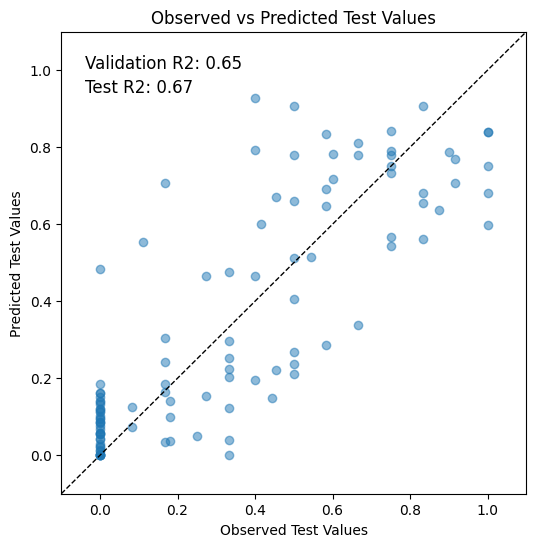

In [ ]:
min_val = min(min(y_pred), min(y_test)) - 0.1
max_val = max(max(y_pred), max(y_test)) + 0.1

plt.figure(figsize=(6, 6))
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
plt.scatter(y_test, y_pred, alpha=0.5)

plt.xlabel('Observed Test Values')
plt.ylabel('Predicted Test Values')
plt.title('Observed vs Predicted Test Values')
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.text(
    0.05, 0.95,
    f'Validation R2: {ridge.best_score_:0.2f}',
    transform=plt.gca().transAxes, fontsize=12,
    verticalalignment='top'
)
plt.text(
    0.05, 0.90,
    f'Test R2: {r2:.2f}',
    transform=plt.gca().transAxes, fontsize=12,
    verticalalignment='top'
)

plt.show()

In [ ]:
features = pd.read_feather(f"{local_dir}/global_quarterly_2018q4_features.feather")

features = gpd.GeoDataFrame(
    features,
    geometry=gpd.points_from_xy(features.lon, features.lat),
    crs="EPSG:4326"
  )
features.geometry = features.geometry.buffer(0.005, cap_style=3)
features.head()

<ipython-input-13-77616025ea5d>:8: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features.geometry = features.geometry.buffer(0.005, cap_style=3)


,lat,lon,planet_0,planet_1,planet_2,planet_3,planet_4,planet_5,planet_6,planet_7,...,planet_3991,planet_3992,planet_3993,planet_3994,planet_3995,planet_3996,planet_3997,planet_3998,planet_3999,geometry
0,9.335,0.825,0.118975,0.052953,0.430502,0.103391,0.063195,0.214984,0.101966,0.040231,...,1.874205,0.711778,0.639545,0.732156,0.602570,1.181959,0.477939,1.032513,1.835547,"POLYGON ((0.83 9.34, 0.83 9.33, 0.82 9.33, 0.8..."
1,7.835,1.425,0.018034,0.002478,0.391211,0.007534,0.040859,0.200633,0.003426,0.024903,...,1.187729,0.327138,1.068480,0.257223,0.432684,0.928777,0.985065,1.126171,1.195884,"POLYGON ((1.43 7.84, 1.43 7.83, 1.42 7.83, 1.4..."
2,6.255,1.595,0.218830,0.091828,0.373547,0.171398,0.037394,0.176217,0.215869,0.031237,...,1.767036,0.921513,0.594582,0.969581,0.670148,1.121789,0.371829,0.901527,2.104784,"POLYGON ((1.6 6.26, 1.6 6.25, 1.59 6.25, 1.59 ..."
3,9.335,0.835,0.065104,0.021399,0.411188,0.057287,0.050411,0.186485,0.033906,0.035619,...,1.763936,0.623144,0.689389,0.647016,0.580793,1.138579,0.577765,1.048798,1.641131,"POLYGON ((0.84 9.34, 0.84 9.33, 0.83 9.33, 0.8..."
4,7.835,1.435,0.016302,0.002380,0.445154,0.007777,0.057143,0.227230,0.003749,0.047565,...,1.162179,0.291900,1.141599,0.223018,0.407675,0.939456,1.079854,1.216648,1.135629,"POLYGON ((1.44 7.84, 1.44 7.83, 1.43 7.83, 1.4..."


<Axes: >

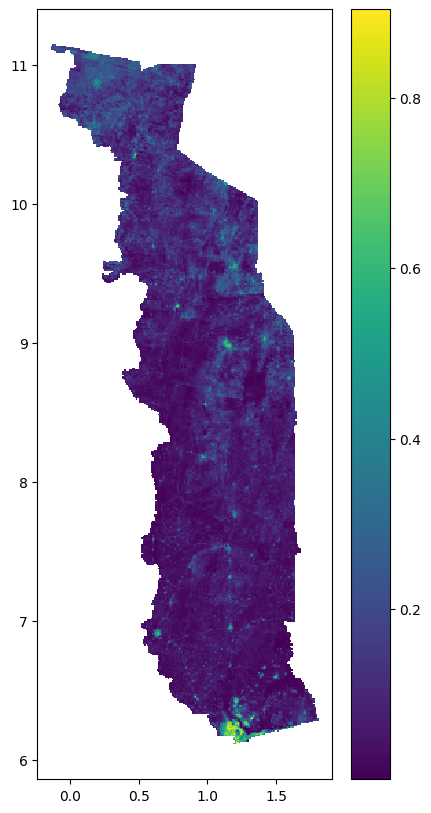

In [ ]:
features.plot(
    column = "planet_0",
    legend = True,
    figsize=(5, 10)
)

In [ ]:
y_pred_full = np.maximum(ridge.predict(features[feature_cols].values), 0)

features['predicted_probability'] = y_pred_full

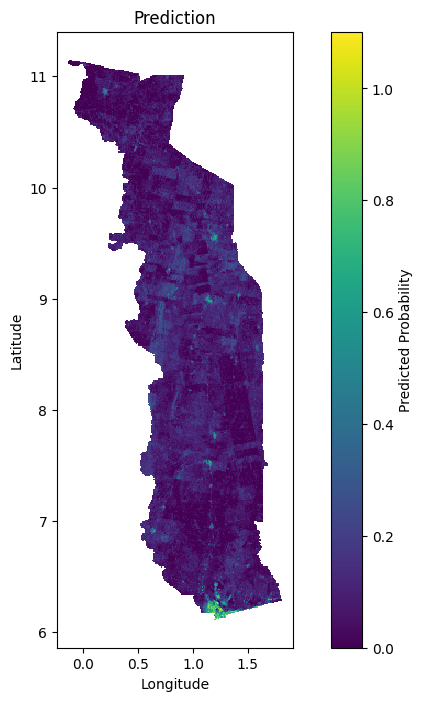

In [ ]:
features.plot(
    column="predicted_probability",
    cmap="viridis",
    legend=True,
    legend_kwds={'label': "Predicted Probability"},
    figsize=(10, 8)
)
plt.title("Prediction")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()